# Cross-Validation for Reliable Model Assessment

This notebook introduces [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), a powerful technique to assess model performance more reliably and evaluate how well a model will generalize to unseen data.

**When to use it?**

Cross-validation helps you:
- Estimate generalization error more reliably than a single train/test split.
- Diagnose model issues like underfitting or overfitting.
- Select the best model or hyperparameters, including regularization strength.

**Objectives:**
- Understand cross-validation concepts
- Apply k-fold cross-validation to regression models
- Use interactive widgets to explore results

In [1]:
# Import libraries and load data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import ipywidgets as widgets

# Load dataset
file_path = '../../data/SuperMarketAnalysis.csv'
df = pd.read_csv(file_path)

## What is Cross-Validation?

Cross-validation splits the data into multiple parts (folds), trains the model on some folds, and tests it on the remaining. This process is repeated to get a more robust estimate of model performance.

**K-Fold Cross-Validation:** 
1. Divide your data into k equal parts (folds)
2. For each fold: 
    - train the model on k-1 folds
    - test on the remaining fold
3. Average the performance across all k folds

![cross_validation](../images/cross_validation.png)

Let's apply k-fold cross-validation to our regression models.

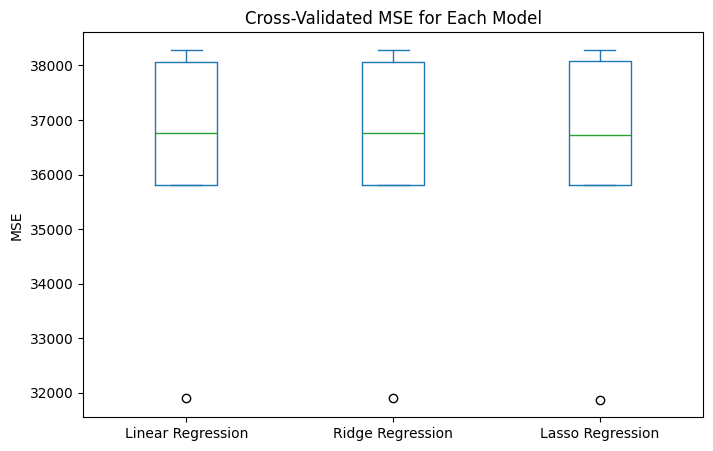

In [2]:
# Prepare data
features = ['Unit price', 'Branch', 'Product line', 'Gender', 'Customer type']
df_encoded = pd.get_dummies(df[features], drop_first=True)
X = df_encoded
y = df['Sales']

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=10000)
}

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_results[name] = -scores

# Visualize
results_df = pd.DataFrame(cv_results)
results_df.plot(kind='box', figsize=(8,5))
plt.title('Cross-Validated MSE for Each Model')
plt.ylabel('MSE')
plt.show()

During cross-validation, we use `neg_mean_squared_error` because scikit-learn's `cross_val_score` convention is that higher scores are better. 
Since mean squared error (MSE) is a loss (lower is better), it is returned as a negative value. We negate it later to get positive MSE values for interpretation.

In [3]:
# Interactive: Select model and see fold scores
@widgets.interact(model=list(models.keys()))
def show_cv_scores(model):
    scores = cv_results[model]
    print(f"{model} CV MSE scores: {scores.round(2)}")
    print(f"Mean MSE: {scores.mean():.2f}")

interactive(children=(Dropdown(description='model', options=('Linear Regression', 'Ridge Regression', 'Lasso R…

Although MSE values remain high, we notice that the scores per model are not too far off from each other. Therefore it seems like our model is not unstable and it seems to be not overfitting. If we look back to [01_regression.ipynb](01_regression.ipynb), MSE was high for both train and test set 



**What is overfitting?**
<details>
        <summary>Answer: Click to show</summary>
    Overfitting is when a model learns _too much_ from the training data. Therefore it performs really well on the train test, but very poorly on new/unseen data.
</details>


## Why use cross-validation?
- Better model evaluation: reduces the chance that your train/test split gives misleading performance
- Use more data for training: every sample gets to be in the test set once and training set k-1 times
- More robust and helps detect overfitting: if test performance varies a lot across folds, your model might be overfitting or is might be unstable

## When to use cross-validation?
- You want reliable evluation on limited data
- You're comparing models or hyperparameters
- You're tuning hyperparameters
- You don't have a separate validation set

## When NOT to use cross-validation?
- On huge datasets where training k times is too expensive
- When data is time-dependent
- When dealing with group related data

## Conclusion

- Cross-validation provides a more reliable estimate of model performance
- Use it to compare models and avoid overfitting